In [1]:
# Uncomment the approiate lines if you get ModuleNotFoundError
#!pip install --user biopython
#!pip install --user numpy
#!pip install --user matplotlib
!pip install --user scipy

In [32]:
from Bio import pairwise2

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

from datetime import datetime

In [27]:
# This notebook is intended as a method to downsample redundant sequences
# from an unaligned fasta-formatted file, based on sequence similarity. 
# Aligned fasta files are treated as though they were unaligned.
# Not at all high-throughput. Designed for targetted phylogenies of genes of interest.

# Define path to input file and desired output path and name
# (If this notebook is in the same directory as your files,
# you can just use the file names)
fastaPath = "M10_40_HEHM.afa"
outPath = "M10_40_HEHM_NR.afa"

# Define the minimum proportion of identical sites at
# which to deem a sequence redundant (and therefore exclude it)
# The lower the value, the more sequences will be removed.
redundancyCutoff = 0.95

In [35]:
# Read the fasta file and store it as a list of lists sorted 
# by sequence length, long to short. 
# [["ID1", "sequence1"], ["ID2", "sequence2"], ...]

seqList = []
with open(fastaPath) as inFile:
    cur = None
    for line in inFile:
        line = line.strip()
        if not line:
            continue
        if line[0] == '>':
            if cur:
                seqList.append(cur)
            cur = [line[1:], ""]
        else:
            cur[1] += line.replace('-', '')

seqList.sort(key=lambda x:-len(x[1]))
seqList = seqList[:]

File contains 16989 sequences 
Average sequence length: 146.92783565836717


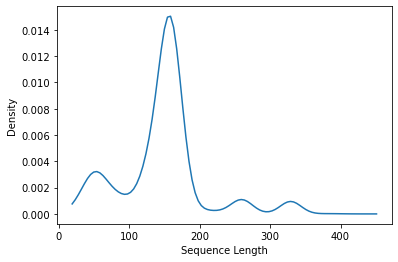

In [39]:
# Plot density distribution of sequence lengths.
# A step to remove especially long or short sequences
# could be added here, but I personally prefer to do that
# after I've seen the alignment. A ton of the short sequences
# will be deemed redundant anyway.

lengths = np.array([len(seq[1]) for seq in seqList])
density = gaussian_kde(lengths)
# Decrease this value to increase resolution:
density.covariance_factor = lambda : .25 
density._compute_covariance()
xs = np.linspace(int(min(lengths) * 0.9), int(max(lengths) * 1.1), 100)

fig, ax = plt.subplots()
ax.plot(xs, density(xs))
ax.set_xlabel("Sequence Length")
ax.set_ylabel("Density")
print("File contains", lengths.shape[0], "sequences", "\nAverage sequence length:", np.mean(lengths))

In [ ]:
# Pairwise align all pairs of sequences, except for those already 
# determined to be redundant (in previous iterations of the loop). 
# Compare percentage of matching sites to redunancy cutoff.

# Since the list of sequences is sorted by descending length,
# the longer sequence is always kept when two sequences are
# found to be redundant. Probably debatable.

# Runtime grows exponentially with number of sequences and with 
# average sequence length, but using a lower redundancy cutoff can 
# bring it closer to linear

redundantIndices = []
numSeqs = len(seqList)
for i in range(numSeqs - 1):
    start = datetime.now()
    if i in redundantIndices:
        continue
    curID, curSeq = seqList[i]
    
    for j in range(i + 1, numSeqs):
        if j in redundantIndices:
            continue
        compID, compSeq = seqList[j]
        numIdent = pairwise2.align.globalmx(curSeq, compSeq, 1, 0, score_only=True)
        # Calculating percent identical sites using the length of the shorter sequence
        # as the denominator, as the length of the shorter sequence is the maximum number
        # of identical sites
        percIdent = numIdent / len(compSeq)
        #print(i, j, percIdent, percIdent > redundancyCutoff)
        
        if percIdent > redundancyCutoff:
            #print(i, len(curSeq), j, len(compSeq), numIdent, percIdent)
            #print(pairwise2.format_alignment(*pairwise2.align.globalmx(curSeq, compSeq, 1, 0)[0]))
            redundantIndices.append(j)
            
#print(redundantIndices)
print(len(redunantIndices), "redundant sequences found.\nTotal runtime:", datetime.now() - start)

In [38]:
with open(outPath, 'w') as outFile:
    for i in [x for x in range(numSeqs) if x not in redundantIndices]:
        seqID, seq = seqList[i]
        outFile.write(">" + seqID + "\n" + seq + "\n")
        
print("Output saved to %s\n%i sequences removed, %i sequences remain" % (outPath, len(redundantIndices), numSeqs - len(redundantIndices)))

Output saved to M10_40_HEHM_NR.afa
10223 sequences removed, 6766 sequences remain
